# Playground with sampled data from KiT-RT

### Setup

In [1]:
using KitBase, Plots, JLD2, Distributions, LinearAlgebra, Flux
using Flux: onecold, @epochs

┌ Info: Kinetic will run serially
└ @ KitBase /home2/vavrines/.julia/packages/KitBase/YV1tk/src/KitBase.jl:61
┌ Info: Kinetic will run with CUDA
└ @ KitBase /home2/vavrines/.julia/packages/KitBase/YV1tk/src/KitBase.jl:65
┌ Info: 1: NVIDIA GeForce RTX 3070
└ @ KitBase /home2/vavrines/.julia/packages/KitBase/YV1tk/src/KitBase.jl:67
┌ Info: Scalar operation is disabled in CUDA
└ @ KitBase /home2/vavrines/.julia/packages/KitBase/YV1tk/src/KitBase.jl:69


In [217]:
function regime_data(w, sw, f, u, K, Kn, μ=ref_vhs_vis(Kn, 1.0, 0.5), ω=0.81)
    gam = heat_capacity_ratio(K, 1)
    prim = conserve_prim(w, gam)
    Mu, Mxi, _, _1 = gauss_moments(prim, K)
    a = pdf_slope(prim, sw, K)
    swt = -prim[1] .* moments_conserve_slope(a, Mu, Mxi, 1)
    A = pdf_slope(prim, swt, K)
    tau = vhs_collision_time(prim, μ, ω)
    fr = chapman_enskog(u, prim, a, A, tau)
    L = norm((f .- fr) ./ prim[1])

    x = [w; sw; tau]
    y = ifelse(L <= 0.005, [1.0, 0.0], [0.0, 1.0])
    return x, y
end

function regime_number(Y, rg=1)
   idx = 0
    for i in axes(Y, 2)
       if Y[1, i] == rg
            idx += 1
        end
    end
    println("NS regime: $(idx) of $(size(Y, 2))")
    return nothing
end

function accuracy(nn, X, Y)
    Y1 = nn(X)

    YA1 = [onecold(Y1[:, i]) for i in axes(Y1, 2)]
    YA = [onecold(Y[:, i]) for i in axes(Y, 2)]

    accuracy = 0.0
    for i in eachindex(YA)
        if YA[i] == YA1[i]
            accuracy += 1.0
        end
    end
    accuracy /= length(YA)

    return accuracy
end

accuracy (generic function with 1 method)

### Dataset

In [255]:
file = open("../../../data/1d/a3_ev5.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[3:end];

In [256]:
file = open("../../../data/1d/a6_ev5.csv")
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = [pdfs; data[3:end]]

file = open("../../../data/1d/a8_ev5.csv")
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = [pdfs; data[3:end]]
nd = length(pdfs) ÷ 2

6003

In [257]:
vs = VSpace1D(-5.0, 5.0, length(data[1]), data[1], data[1][2:end] .- data[1][1:end-1], data[2])

VelocitySpace1D{Float64,Int64,Vector{Float64},Vector{Float64}}
domain: (-5.0,5.0)
resolution: 100
ghost: 0


In [258]:
dist = Uniform(0.004, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.00001, 1.0)
kns = rand(dist, nd);
dist = Uniform(0.1, 1.0)
rhos = rand(dist, nd);

In [259]:
X = [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
Y = [1.0, 0.0]
for i = 1:nd
    try
        #fL = pdfs[i]; fR = pdfs[nd*2-i]
        fL = pop!(pdfs) .* pop!(rhos); fR = pop!(pdfs) .* pop!(rhos) # shuffle
        wL = moments_conserve(fL, vs.u, vs.weights); wR = moments_conserve(fR, vs.u, vs.weights)
        #@show wL, wR
        w = @. (wL + wR) / 2
        sw = @. (wR - wL) / dxs[i]
        f = @. (fL + fR) / 2
        
        tmpx, tmpy = regime_data(w, sw, f, vs.u, 0, kns[i])
        X = hcat(X, tmpx)
        Y = hcat(Y, tmpy)
    catch
    end
end

In [260]:
regime_number(Y)

NS regime: 168 of 3000


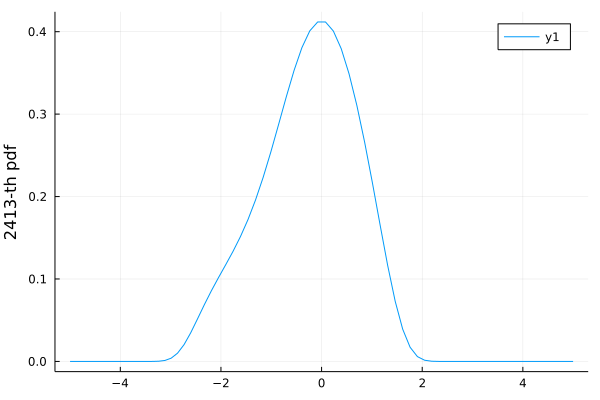

In [208]:
idx = Int(floor(rand() * size(X, 2)))
plot(data[1], data[idx], ylabel="$(idx)-th pdf")

### Model

In [224]:
@load "../nn.jld2" nn

1-element Vector{Symbol}:
 :nn

In [261]:
accuracy(nn, X, Y)

0.9423333333333334

In [262]:
data = Flux.Data.DataLoader((X, Y), shuffle = true)
ps = Flux.params(nn)
sqnorm(x) = sum(abs2, x)
loss(x, y) = sum(abs2, nn(x) - y) / size(x, 2) #+ 1e-6 * sum(sqnorm, ps)
cb = () -> println("loss: $(loss(X, Y))")
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [263]:
@epochs 50 Flux.train!(loss, ps, data, opt, cb = Flux.throttle(cb, 1))

┌ Info: Epoch 1
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10570831551668361
loss: 0.10335545363912388


┌ Info: Epoch 2
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09952715330333488


┌ Info: Epoch 3
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10037609985886062


┌ Info: Epoch 4
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1046458053609582


┌ Info: Epoch 5
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10146299737811408


┌ Info: Epoch 6
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09824401591930071


┌ Info: Epoch 7
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09736370280279459


┌ Info: Epoch 8
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.11599570178474837


┌ Info: Epoch 9
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10201713641902649


┌ Info: Epoch 10
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.12973952197471655


┌ Info: Epoch 11
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09954605891260052


┌ Info: Epoch 12
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09799180972457515


┌ Info: Epoch 13
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.10123553890683733


┌ Info: Epoch 14
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09685225621941773


┌ Info: Epoch 15
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09548397850458719


┌ Info: Epoch 16
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09918320048975386


┌ Info: Epoch 17
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09536554267417932


┌ Info: Epoch 18
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09587485417265221


┌ Info: Epoch 19
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.0931199784230256


┌ Info: Epoch 20
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09578479927901189


┌ Info: Epoch 21
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.0945617892117471


┌ Info: Epoch 22
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.0916508844773017


┌ Info: Epoch 23
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09301302607513318


┌ Info: Epoch 24
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09521776201507055


┌ Info: Epoch 25
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09689473221694893


┌ Info: Epoch 26
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09191884807921401


┌ Info: Epoch 27
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09323244238425962


┌ Info: Epoch 28
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09838615372042567


┌ Info: Epoch 29
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09619492874323411


┌ Info: Epoch 30
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.0919083113707297


┌ Info: Epoch 31
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09255374525521029


┌ Info: Epoch 32
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09048212725885021


┌ Info: Epoch 33
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09226827482847705


┌ Info: Epoch 34
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.0892775179962238


┌ Info: Epoch 35
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.17511650900948733


┌ Info: Epoch 36
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09583736740408814


┌ Info: Epoch 37
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.08965129532969465


┌ Info: Epoch 38
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09049989510155888


┌ Info: Epoch 39
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 40
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.08948841782941254
loss: 0.08973490223008719


┌ Info: Epoch 41
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.08952034498933366


┌ Info: Epoch 42
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09022018316278174


┌ Info: Epoch 43
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1704755442249523


┌ Info: Epoch 44
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1359825551879489


┌ Info: Epoch 45
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09329096016486044


┌ Info: Epoch 46
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09087790536267525


┌ Info: Epoch 47
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.0893045493539576


┌ Info: Epoch 48
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.09007659592401605


┌ Info: Epoch 49
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.08942899429687921


┌ Info: Epoch 50
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


In [265]:
cd(@__DIR__)
@save "nn_rif.jld2" nn # reinforcement neural model

### Test

In [264]:
accuracy(nn, X, Y)

0.947

In [215]:
nn(X)

2×3000 Matrix{Float64}:
 0.0349645  0.0349645  0.0349645  …  0.0349645  0.0349645  0.0349645
 0.965223   0.965223   0.965223      0.965223   0.965223   0.965223

In [216]:
X

7×3000 Matrix{Float64}:
 1.0   0.724725   0.237012    0.467263   …   0.712398    0.844528
 0.0   0.307156  -0.0186205   0.0443902      0.0082256  -0.00145812
 1.0   0.359093   0.0496517   0.130641       0.324511    0.385258
 0.0  -1.45087   14.2781     -2.5508        -7.4714      2.8997
 0.0  12.2489    -1.82491    -4.02964       -0.386656    0.425634
 0.0   8.31999    3.10256    -3.90737    …  -3.41789     1.31224
 1.0   0.21187    3.25086     1.30511        0.352793    0.539888